# Kalman Filtering
### Lehner White

In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import seaborn

## Problem 1:

In [2]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector. 
        """    
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        return
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman 
        system.
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        m, n = self.H.shape[0], len(x0)

        states = np.zeros((N,n))
        states[0] = x0
        
        obs = np.zeros((N, m))
        obs[0] = x0[:m]
        
        for i in xrange(N-1):
            eps = np.random.multivariate_normal(np.zeros(Q.shape[0]), Q)
            delt = np.random.multivariate_normal(np.zeros(R.shape[0]), R)
            
            states[i+1] = self.F.dot(states[i]) + self.u + eps
            obs[i+1] = self.H.dot(states[i]) + delt
            
        return states, obs

    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        m, n = self.H.shape[0], len(x)
        N = z.shape[0]
        
        out = np.zeros((N,n))
        out[0] = x
        
        for i in xrange(N-1):
            out[i+1] = self.F.dot(out[i]) + self.u
            P = self.F.dot(P).dot(self.F.T) + self.Q
            y = z[i+1] - self.H.dot(out[i+1])
            S = self.H.dot(P).dot(self.H.T) + self.R
            K = P.dot(self.H.T).dot(np.linalg.inv(S))
            out[i+1] = out[i+1] + K.dot(y)
            P = (np.eye(P.shape[0]) - K.dot(self.H)).dot(P)
        return out
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
        The next k predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
        
        for i in xrange(k-1):
            out[i+1] = self.F.dot(out[i]) + self.u
            
        return out
    
    def rewind(self,x,k):
        """
        Predict the k states preceding the current state estimate x.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
        The k preceding predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
                
        for i in xrange(k-1):
            out[i+1] = np.linalg.inv(self.F).dot(out[i] - self.u)
            
        return out
        

## Problem 2

In [3]:
F = np.array([[1, 0, 0.1, 0],
              [0, 1, 0, 0.1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
Q = np.eye(4) * 0.1
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
R = np.eye(2) * 5000
u = np.array([0, 0, 0, -0.98])

k = KalmanFilter(F, Q, H, R, u)

## Problem 3:

In [4]:
x0 = np.array([0, 0, 300, 600])
states, obs = k.evolve(x0, 1250)

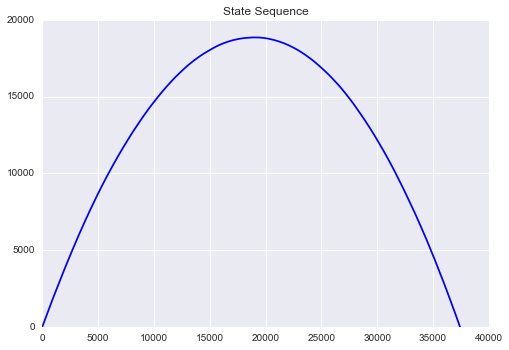

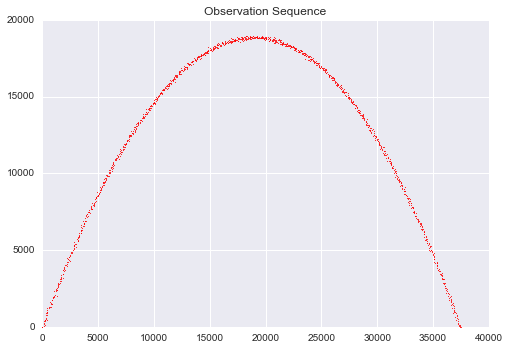

In [5]:
plt.plot(states[:,0], states[:,1], 'b')
plt.title('State Sequence')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.scatter(obs[:,0], obs[:,1], color='r', s=0.5)
plt.title('Observation Sequence')
plt.xlim(0)
plt.ylim(0)
plt.show()

## Problem 5:

In [6]:
x = states[200]
vel = np.zeros((9,2))
for i in xrange(9):
    vel[i] = obs[201+i] - obs[200+i]
x[2:] = np.mean(vel, axis=0)
P = 10**6 * Q
z = obs[200:801]

est = k.estimate(x, P, z)

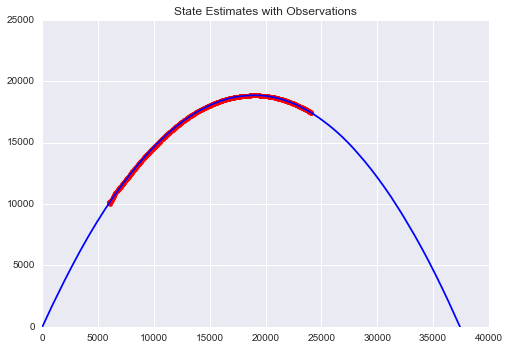

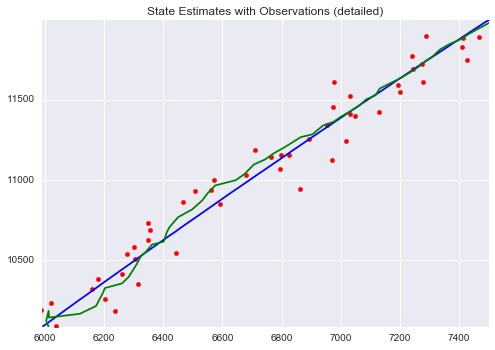

In [7]:
plt.plot(states[:,0], states[:,1], 'b')
plt.scatter(est[:,0], est[:,1], color='r')
plt.title('State Estimates with Observations')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(est[:,0], est[:,1], 'g')
plt.scatter(obs[:,0], obs[:,1], color='r')
plt.title('State Estimates with Observations (detailed)')
plt.xlim(states[200, 0], states[250, 0])
plt.ylim(states[200, 1], states[250, 1])
plt.show()

## Problem 7:

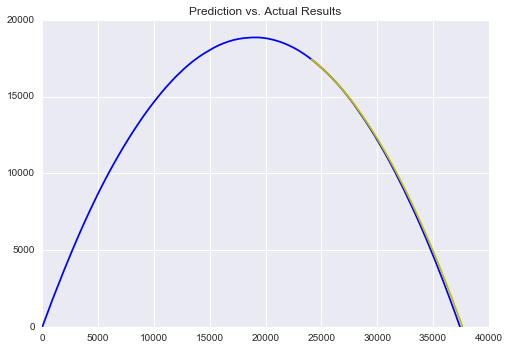

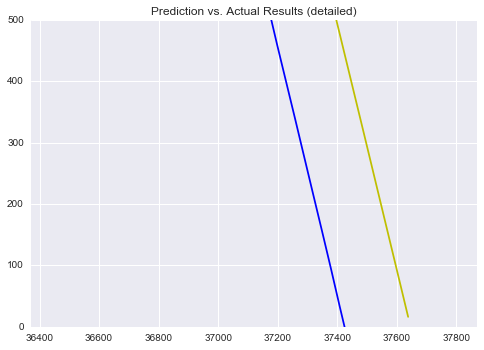

In [8]:
x = est[-1]
pred = k.predict(x, 450)

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(pred[:,0], pred[:,1], 'y')
plt.title('Prediction vs. Actual Results')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(pred[:,0], pred[:,1], 'y')
plt.title('Prediction vs. Actual Results (detailed)')
plt.xlim(states[1220, 0] - 500, states[1220, 0]+1000)
plt.ylim(0, 500)
plt.show()

## Problem 9:

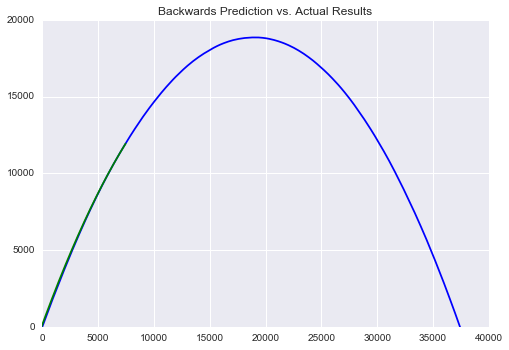

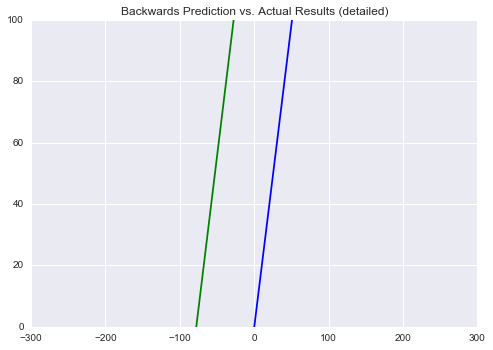

In [9]:
x = est[50]
prev = k.rewind(x, 450)

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards Prediction vs. Actual Results')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards Prediction vs. Actual Results (detailed)')
plt.xlim(-300, 300)
plt.ylim(0, 100)
plt.show()

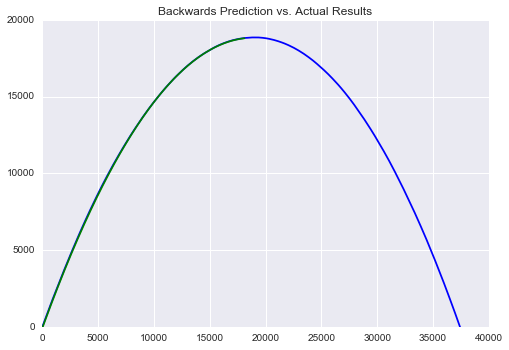

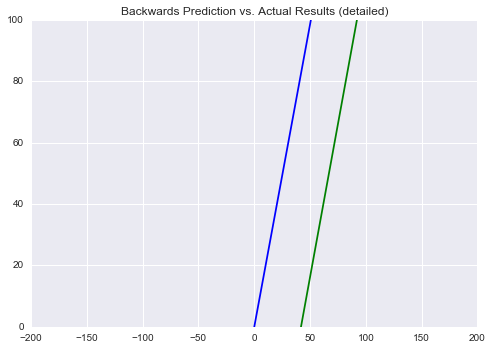

In [10]:
x = est[400]
prev = k.rewind(x, 800)

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards Prediction vs. Actual Results')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards Prediction vs. Actual Results (detailed)')
plt.xlim(-200, 200)
plt.ylim(0, 100)
plt.show()